# Multilayer Perceptron

## The Kinds of Functions that an MLP Can Represent

In [23]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sklearn.metrics
import pandas as pd 
import numpy as np 

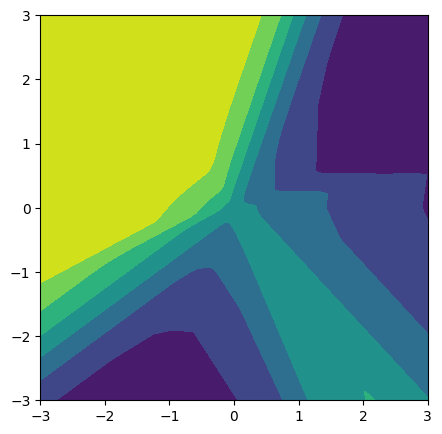

In [21]:
#
# Create a two dimensional grid that we want to makes predictions over
#

# The number of points in each dimension
N = 100
xs = jnp.linspace(-3, 3, N)
x1s, x2s = jnp.meshgrid(xs, xs) # creates all combinations of xs * xs
# so now x1s and x2s have shape 100x100

# Now we make the actual inputs into the neural network
# x1s.flatten() gives us a shape of 100*100 = 10,000
# and similary for x2s
X = jnp.vstack((x1s.flatten(), x2s.flatten())).T

# First, let's prepare a random key
rng = jax.random.key(123413)
n_hidden = 20 # number of hidden units in the first hidden layer

#
# Now let's initialize the weights of the neural network
#
params = {} # initialize an empty dictionary

# weights from inputs to hidden neurons (2xH)
params['W_input_hidden'] = jax.random.normal(rng, (2, n_hidden)) 
rng, _ = jax.random.split(rng)  # move to the next random key

# bias of the hidden neurons is initialized to zero
params['b_hidden'] = jnp.zeros(n_hidden)

# weights from the hidden neurons to the output neuron (shape is H)
params['W_hidden_output'] = jax.random.normal(rng, (n_hidden,)) 
rng, _ = jax.random.split(rng) # move to next random key

# finally, initialize the bias of the output neuron 
params['b_output'] = 0.0

# 
# Now we can actually run the forward pass of the network
#

# compute the inputs into the neurons
# 1xH + Nx2 @ 2xH = 1xH + NxH = NxH
hidden_inputs = params['b_hidden'][None,:] + X @ params['W_input_hidden']

# next, we apply the non-linearity to those inputs
#hidden_activations = jnp.tanh(hidden_inputs) # NxH
hidden_activations = jnp.maximum(0, hidden_inputs) # <-- ReLU

# now we compute the output
# 1 + NxH @ H = 1 + N = N 
f = params['b_output'] + hidden_activations @ params['W_hidden_output']
p = 1/(1+jnp.exp(-f)) # <-- sigmoid function

# Now we want to plot the result

# first, we need to reshape the output from N (10,000) to 100x100 
P = jnp.reshape(p, (N, N)) # 10,000 -> 100x100

f, ax = plt.subplots(1, 1, figsize=(5,5))
ax.contourf(x1s, x2s, P)

# Implementing the MLP

In [117]:
def prepare_inputs(input_df):
    """
        Prepares the input features that will be fed into the model.

        Inputs:
            input_df: the input dataframe into the function. Should consist ONLY of input features.
        Outputs:
            Z: the input feature matrix of size NxK, where K is the number of features
    """
    # Let's identify categorical columns in a dataframe
    categorical_cols = input_df.select_dtypes(include='object').columns
    
    # Let's identify the numeric columns in the dataframe
    numeric_cols = input_df.select_dtypes(include='number').columns

    # We want to construct the input features into the model
    # We will use a numpy array that contains both numeric and categorically encoded values
    X = input_df[numeric_cols].to_numpy() # (NxK)
    
    # Now we need to z-score the numeric features so that they can lead to efficient learning
    col_means = np.mean(X, axis=0) # K
    col_stds = np.std(X, axis=0, ddof=1) # K
    
    # Z-score
    # (NxK - 
    #  1xK) 
    #  / 
    #  (1xK)
    Z = (X - col_means[None, :]) / col_stds[None, :]
    
    # Now we want to code the categorical columns using one-hot encoding
    for col in categorical_cols:
        # NxC (C is the number of unique values in the column)
        # So for origin this will be Nx3 
        dummies = pd.get_dummies( input_df[col] ).to_numpy() 
        
        # concatenate dummies matrix onto Z
        #print(Z.shape)
        #print(dummies.shape)
        Z = np.hstack((Z, dummies)) 
    
    # finally we want to add a column of ones at the start of Z
    ones_col = np.ones((Z.shape[0], 1)) # Nx1
    
    Z = np.hstack((ones_col, Z))

    return Z

def forward_fn(params, Z):
    """
        The MLP forward function.
        This is a neuron network with one hidden layer and ReLU activations.
        
        Inputs:
            params: the weight of the model
            Z: the input feature matrix, as returned by prepare_inputs (size NxK)
        Output:
            yhat: the model's predictions (size N)
    """
    # compute the inputs into the neurons
    # 1xH + Nxd @ dxH = 1xH + NxH = NxH
    hidden_inputs = params['b_hidden'][None,:] + Z @ params['W_input_hidden']
    
    # next, we apply the non-linearity to those inputs
    #hidden_activations = jnp.tanh(hidden_inputs) # NxH
    hidden_activations = jnp.maximum(0, hidden_inputs) # <-- ReLU
    
    # now we compute the output
    # 1 + NxH @ H = 1 + N = N 
    f = params['b_output'] + hidden_activations @ params['W_hidden_output']
    p = 1/(1+jnp.exp(-f)) # <-- sigmoid function (the probability of a positive)

    # so that the log doesn't blow up
    p = jnp.clip(p, 0.01, 0.99)
    jnp.log_simoid
    return p

def predict(params, input_df):
    """
        Convienience function that prepares inputs and runs the forward function.

        Inputs:
            params: the weights of the model
            input_df: input data frame (input features only, no output column).
        Output:
            yhat: the model's predictions (size N)
    """
    Z = prepare_inputs(input_df)
    return forward_fn(params, Z)

def loss_fn(params, Z, y):
    """
        Computes the mean squared error loss function for the model.

        Inputs:
            params: the weights of the model
            Z: the input feature matrix, as returned by prepare_inputs (size NxK)
            y: actual observations (size N)
        Output:
            mse: mean squared error
    """
    p = forward_fn(params, Z) # N

    # Log Probability of each data point, given the model (shape N)
    log_probability_of_data = y * jnp.log(p) + (1-y) * jnp.log(1-p)

    # We want to maximize the log probability of the data under the model
    # but gradient descent minimizes a loss
    # So we want to minimize the negative log probability
    loss = -jnp.mean(log_probability_of_data)
    
    return loss 

def optimize(rng, input_df, y, learning_rate, epochs, n_hidden):
    """
        Input parameters:
            rng: the random key
            input_df: dataframe containing input columns
            y: a vector of outputs that we wish to predict
            learning_rate: how quickly we want gradient descent learning
            epochs: the number of steps of gradient descent
            n_hidden: the number of hidden units
        Output:
            params: fitted model parameters
    """

    # To make this work, we need to convert y to jax
    y = jnp.array(y)
    
    # the magic: the gradient function
    # Creates a function that can calculate the  gradient of the model
    grad_fn = jax.grad(loss_fn) 
    
    # Prepare our inputs into the linear regression
    Z = prepare_inputs(input_df) # NxK

    #
    # Initialize the parameters
    #
    params = {} # initialize an empty dictionary
    # weights from inputs to hidden neurons (dxH)
    n_inputs = Z.shape[1]
    params['W_input_hidden'] = jax.random.normal(rng, (n_inputs, n_hidden)) / jnp.sqrt(n_inputs)
    rng, _ = jax.random.split(rng)  # move to the next random key
    
    # bias of the hidden neurons is initialized to zero
    params['b_hidden'] = jnp.zeros(n_hidden)
    
    # weights from the hidden neurons to the output neuron (shape is H)
    params['W_hidden_output'] = jax.random.normal(rng, (n_hidden,)) / jnp.sqrt(n_hidden)
    rng, _ = jax.random.split(rng) # move to next random key
    
    # finally, initialize the bias of the output neuron 
    params['b_output'] = 0.0
    
    # Run gradient descent loop
    for i in range(epochs):

        # Compute the gradient of the loss function with respect
        # to all model parameters
        W_grad = grad_fn(params, Z, y)
        
        # Update the parameters
        for key in params:
            params[key] = params[key] - W_grad[key] * learning_rate

    # params is the fitted parameter values
    return params

def mlp_train_test_function(rng,
                            train_df, 
                            test_df, 
                            input_cols, 
                            output_col,
                            n_hidden):

    # build the training input data frame
    train_input_df = train_df[input_cols]

    # build the training outputs
    y = train_df[output_col].to_numpy()
    
    # Optimize the model using gradient descent
    best_params = optimize(rng = rng,
                           input_df = train_input_df,
                           y = y,
                           learning_rate = 0.1,
                           epochs = 100,
                           n_hidden = n_hidden)

    # build the testing input data frame
    test_input_df = test_df[input_cols]

    # Make predictions on the test set
    yhat = predict(params = best_params, input_df = test_input_df)
    
    # Calculate error of those predictions
    ytest = test_df[output_col].to_numpy()
    
    return sklearn.metrics.accuracy_score(ytest, yhat > 0.5)
# load the example 'hard' dataset
df = pd.read_csv("../data/nonseparable_binary_data.csv")
# initialize random number generator
rng = jax.random.key(5635636)
# compute accuracy on the training set, using an MLP with 2 hidden units
accuracy = mlp_train_test_function(rng,
                                   train_df = df,
                                   test_df = df,
                                   input_cols = ['x1','x2'],
                                   output_col = 'y',
                                   n_hidden=20)
accuracy

0.894

# Evaluation Metrics

In [118]:
# Let's define a toy dataset
# where we have some actual observations and corresponding predictions
y_actual = np.array([0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0])
y_pred = np.array([0.06, 0.92, 0.86, 0.03, 0.4, 0.7, 
                   0.23, 0.4, .2, 0.8, 0.9, 0.65, 0.75, 0.4])


In [119]:
# Now we want to see the metrics that require hard decisions
y_pred_hard = y_pred > 0.5

sklearn.metrics.accuracy_score(y_actual, y_pred_hard)

0.7142857142857143

In [120]:
np.ones_like(y_actual)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [121]:
# Let's also define our null model. 
# This will be a model that always predicts the proportion of positives on the dataset
y_pred_null = np.ones_like(y_actual) * np.mean(y_actual)
y_pred_null_hard = y_pred_null > 0.5

sklearn.metrics.accuracy_score(y_actual, y_pred_null_hard)

0.6428571428571429

In [122]:
sklearn.metrics.balanced_accuracy_score(y_actual, y_pred_hard)

0.7333333333333334

In [123]:
sklearn.metrics.balanced_accuracy_score(y_actual, y_pred_null_hard)

0.5

In [124]:
sklearn.metrics.recall_score(y_actual, y_pred_hard)

0.6666666666666666

In [125]:
sklearn.metrics.recall_score(y_actual, y_pred_null_hard)

1.0

In [126]:
sklearn.metrics.precision_score(y_actual, y_pred_hard)

0.8571428571428571

In [127]:
sklearn.metrics.precision_score(y_actual, y_pred_null_hard)

0.6428571428571429

In [128]:
sklearn.metrics.f1_score(y_actual, y_pred_hard)

0.75

In [129]:
sklearn.metrics.f1_score(y_actual, y_pred_null_hard)

0.782608695652174

In [130]:
# Let's look at the metrics that are based on soft predictions

sklearn.metrics.roc_auc_score(y_actual, y_pred) # Not the hard predictions

0.7555555555555555

In [131]:
sklearn.metrics.roc_auc_score(y_actual, y_pred_null) # Not the hard predictions

0.5

In [132]:
# AUC-PR
sklearn.metrics.average_precision_score(y_actual, y_pred) # Not the hard predictions

0.8063492063492064

In [133]:
sklearn.metrics.average_precision_score(y_actual, y_pred_null) # Not the hard predictions

0.6428571428571429

# Let's try to do CV on our model

In [138]:
def cv(df, train_test_fn, folds, random_state):
    """
        Cross-validation: splits dataset into N folds, repeatedly trains on N-1 folds and test on the remaining.

        Inputs:
            df: dataframe of inputs and outputs
            train_test_fn: the training and testing function used
            folds: number of folds
            random_state: pseudo random number generator state
        Output:
            metrics: loss on each split (size N)
    
    """
    # instantiate the splitter
    kf = sklearn.model_selection.KFold(n_splits=folds, 
                                       shuffle=True, 
                                       random_state=random_state)
    
    metrics = []
    for train_index, test_index in kf.split(df):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        
        # evaluate
        metric = train_test_fn(train_df, test_df)
        metrics.append(metric)
    
    return metrics 

def mlp_train_test_function(rng,
                            train_df, 
                            test_df, 
                            input_cols, 
                            output_col,
                            n_hidden):

    # build the training input data frame
    train_input_df = train_df[input_cols]

    # build the training outputs
    y = train_df[output_col].to_numpy()
    
    # Optimize the model using gradient descent
    best_params = optimize(rng = rng,
                           input_df = train_input_df,
                           y = y,
                           learning_rate = 0.1,
                           epochs = 100,
                           n_hidden = n_hidden)

    # build the testing input data frame
    test_input_df = test_df[input_cols]

    # Make predictions on the test set
    yhat = predict(params = best_params, input_df = test_input_df)
    
    # Calculate error of those predictions
    ytest = test_df[output_col].to_numpy()

    # We will return multiple metrics
    yhat_hard = yhat > 0.5

    # this is our null model, and it is based only on the training set
    yhat_null = jnp.mean(y) * jnp.ones_like(ytest)
    yhat_hard_null = yhat_null > 0.5
    
    return dict(
        accuracy = sklearn.metrics.accuracy_score(ytest, yhat_hard),
        accuracy_null = sklearn.metrics.accuracy_score(ytest, yhat_hard_null),
        auc_roc = sklearn.metrics.roc_auc_score(ytest, yhat), # soft decision
        auc_pr = sklearn.metrics.average_precision_score(ytest, yhat),
        auc_pr_null = sklearn.metrics.average_precision_score(ytest, yhat_null)
    )

df = pd.read_csv("../data/nonseparable_binary_data.csv")

# get the metrics on the training set ... just to make sure that the function
# works
metrics = mlp_train_test_function(rng,
                                  train_df = df,
                                  test_df = df,
                                  input_cols = ['x1','x2'],
                                  output_col = 'y',
                                  n_hidden=10)

def factory(rng, input_cols, output_col, n_hidden):

    def train_test_fn(train_df, test_df):

        return mlp_train_test_function(rng,
                                  train_df = train_df,
                                  test_df = test_df,
                                  input_cols = input_cols,
                                  output_col = output_col,
                                  n_hidden=n_hidden)

    return train_test_fn

# Load the spambase dataset
df = pd.read_csv("../data/spambase.csv")

# grab all column names, except the last one
input_cols = df.columns[:-1]

# grab the output column name
output_col = df.columns[-1]

rng = jax.random.key(4234)
train_test_fn = factory(rng,
                        input_cols = input_cols,
                        output_col = output_col,
                        n_hidden = 2)
results = cv(df = df,
             train_test_fn = train_test_fn,
             folds = 5,
             random_state = 234234)
results_df = pd.DataFrame(results)
np.mean(results_df, axis=0)

accuracy         0.912842
accuracy_null    0.605956
auc_roc          0.958677
auc_pr           0.934843
auc_pr_null      0.394044
dtype: float64

In [105]:
a = ['a','b','c','d','e']
a[:-2]

['a', 'b', 'c']